In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder #Handling Categorical Data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #For Data Visualization
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


**Loading Data**

In [2]:
train = pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/train.csv", index_col="row_id", parse_dates=['time'])
test =  pd.read_csv("/kaggle/input/tabular-playground-series-mar-2022/test.csv", index_col="row_id", parse_dates=['time'])

**Handling Categorical Variables and Feature Engineering**

In [3]:
def changetime(df):
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >=5).astype(int)
    
    df['hours'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    
    df['afternoon'] = (df['time'].dt.hour >=12).astype(int)
    
    return df

In [4]:
train = changetime(train)
test = changetime(test)
train.head()

,time,x,y,direction,congestion,month,day,weekday,weekend,hours,minute,afternoon
row_id,,,,,,,,,,,,
0,1991-04-01,0,0,EB,70,4,1,0,0,0,0,0
1,1991-04-01,0,0,NB,49,4,1,0,0,0,0,0
2,1991-04-01,0,0,SB,24,4,1,0,0,0,0,0
3,1991-04-01,0,1,EB,18,4,1,0,0,0,0,0
4,1991-04-01,0,1,NB,60,4,1,0,0,0,0,0


In [5]:
train['road'] = train['x'].astype(str) + train['y'].astype(str) + train['direction']


test['road'] = test['x'].astype(str) + test['y'].astype(str) + test['direction']


le = LabelEncoder()
train['road'] = le.fit_transform(train['road'])
test['road'] = le.transform(test['road'])

train = train.drop(['x','y','direction'], axis=1)
test = test.drop(['x','y','direction'], axis=1)
train.road.nunique()

65

**Checking Null Values**

In [6]:
train.columns

Index(['time', 'congestion', 'month', 'day', 'weekday', 'weekend', 'hours',
       'minute', 'afternoon', 'road'],
      dtype='object')

In [7]:
print("Missing values in Train dataset:",train.isna().any().sum())
print("Missing values in Test dataset:",test.isna().any().sum())

Missing values in Train dataset: 0
Missing values in Test dataset: 0


In [8]:
train.describe()

,congestion,month,day,weekday,weekend,hours,minute,afternoon,road
count,848835.000000,848835.000000,848835.000000,848835.000000,848835.000000,848835.000000,848835.000000,848835.000000,848835.000000
mean,47.815305,6.488935,15.695076,2.988897,0.284631,11.479057,20.012252,0.498813,32.000000
std,16.799392,1.696182,8.792775,2.006717,0.451239,6.926522,16.329937,0.499999,18.761674
min,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,5.000000,8.000000,1.000000,0.000000,5.000000,0.000000,0.000000,16.000000
50%,47.000000,6.000000,16.000000,3.000000,0.000000,11.000000,20.000000,0.000000,32.000000
75%,60.000000,8.000000,23.000000,5.000000,1.000000,17.000000,40.000000,1.000000,48.000000
max,100.000000,9.000000,31.000000,6.000000,1.000000,23.000000,40.000000,1.000000,64.000000


**Mean, Median, Min, Max congestions**

In [9]:
tt = pd.concat([train,test], axis=0)

In [10]:
keys = ['weekday','hours', 'minute', 'road']

temp = tt.groupby(by=keys).mean().reset_index().set_index(keys)
temp['mean congestion'] = temp['congestion']
tt = tt.merge(temp['mean congestion'], how='left', left_on=keys, right_on=keys)

temp = tt.groupby(by=keys).median().reset_index().set_index(keys)
temp['median congestion'] = temp['congestion']
tt = tt.merge(temp['median congestion'], how='left', left_on=keys, right_on=keys)

temp = tt.groupby(by=keys).min().reset_index().set_index(keys)
temp['min congestion'] = temp['congestion']
tt = tt.merge(temp['min congestion'], how='left', left_on=keys, right_on=keys)

temp = tt.groupby(by=keys).max().reset_index().set_index(keys)
temp['max congestion'] = temp['congestion']
tt = tt.merge(temp['max congestion'], how='left', left_on=keys, right_on=keys)

In [11]:
tt.head()

,time,congestion,month,day,weekday,weekend,hours,minute,afternoon,road,mean congestion,median congestion,min congestion,max congestion
0,1991-04-01,70.0,4,1,0,0,0,0,0,0,39.555556,35.0,30.0,80.0
1,1991-04-01,49.0,4,1,0,0,0,0,0,1,30.259259,29.0,13.0,69.0
2,1991-04-01,24.0,4,1,0,0,0,0,0,2,37.962963,24.0,21.0,91.0
3,1991-04-01,18.0,4,1,0,0,0,0,0,3,15.740741,17.0,0.0,26.0
4,1991-04-01,60.0,4,1,0,0,0,0,0,4,61.962963,63.0,52.0,72.0


In [12]:
tt_morning = tt[(tt['hours'] >=6) & (tt['hours'] < 12)]
morning_avg = pd.DataFrame(tt_morning.groupby(by=['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avg = morning_avg.rename(columns={'congestion':'morning_avg'})
tt = tt.merge(morning_avg, on=['month', 'day', 'road'], how='left')

In [13]:
tt.head()

,time,congestion,month,day,weekday,weekend,hours,minute,afternoon,road,mean congestion,median congestion,min congestion,max congestion,morning_avg
0,1991-04-01,70.0,4,1,0,0,0,0,0,0,39.555556,35.0,30.0,80.0,45
1,1991-04-01,49.0,4,1,0,0,0,0,0,1,30.259259,29.0,13.0,69.0,35
2,1991-04-01,24.0,4,1,0,0,0,0,0,2,37.962963,24.0,21.0,91.0,47
3,1991-04-01,18.0,4,1,0,0,0,0,0,3,15.740741,17.0,0.0,26.0,26
4,1991-04-01,60.0,4,1,0,0,0,0,0,4,61.962963,63.0,52.0,72.0,69


**Lag Function**

In [14]:
for delta in range(1,8):
    dy = tt.copy()
    dy['time'] = dy['time'] + pd.Timedelta(delta, unit="d")
    name =f'lag_{delta}'
    dy = dy.rename(columns={'congestion':name})[['time', 'road', name]]
    tt = tt.merge(dy, on=['time', 'road'], how='left')
tt=tt.fillna(tt["congestion"].median())
tt.describe()

,congestion,month,day,weekday,weekend,hours,minute,afternoon,road,mean congestion,...,min congestion,max congestion,morning_avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
count,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,...,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000,851175.000000
mean,47.813063,6.495838,15.734402,2.980680,0.283849,11.495609,20.012218,0.500191,32.000000,47.823916,...,32.550201,65.604937,46.732704,47.799440,47.807869,47.797022,47.790322,47.784575,47.771136,47.762259
std,16.776339,1.698944,8.812568,2.010058,0.450865,6.926540,16.329937,0.500000,18.761674,14.391222,...,16.125031,16.372298,14.274686,16.702694,16.660868,16.613168,16.559131,16.518156,16.468734,16.425705
min,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.307692,...,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,5.000000,8.000000,1.000000,0.000000,5.000000,0.000000,0.000000,16.000000,37.038462,...,20.000000,54.000000,35.000000,35.000000,35.000000,35.000000,35.000000,36.000000,36.000000,36.000000
50%,47.000000,7.000000,16.000000,3.000000,0.000000,12.000000,20.000000,1.000000,32.000000,47.384615,...,31.000000,67.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
75%,60.000000,8.000000,23.000000,5.000000,1.000000,17.000000,40.000000,1.000000,48.000000,58.384615,...,44.000000,78.000000,58.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
max,100.000000,9.000000,31.000000,6.000000,1.000000,23.000000,40.000000,1.000000,64.000000,88.500000,...,77.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


**Handling Outliers**

<AxesSubplot:>

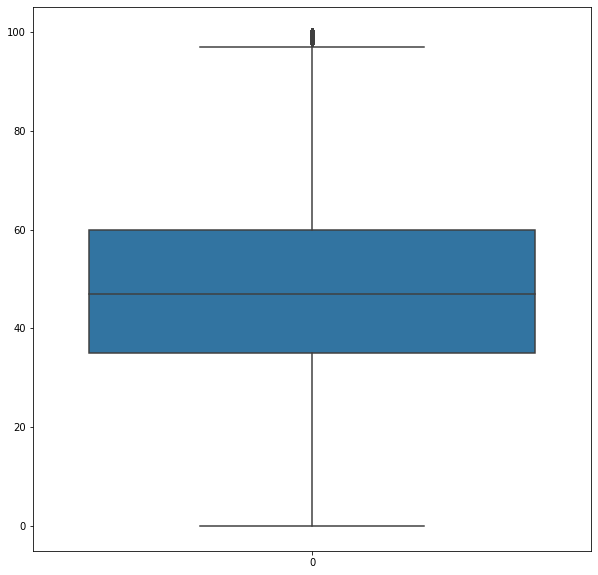

In [15]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train['congestion'])

In [16]:
def outlier_detection(df, column):
    outlier_indices =[]
    
    for x in column:
        q1 = np.percentile(df[x], 25)
        q3 = np.percentile(df[x], 75)
        
        outliers = (q3 - q1)*1.5
        outlier_list_col = df[(df[x] < q1 - outliers) | (df[x] > q1 + outliers)].index
        
        outlier_indices.extend(outlier_list_col)
    
    return outlier_indices

In [17]:
outlier_indices = outlier_detection(tt, ["congestion"])

In [18]:
for i in outlier_indices:
    tt['congestion'][i] = tt['median congestion'][i]

**Data Visualization**

<AxesSubplot:>

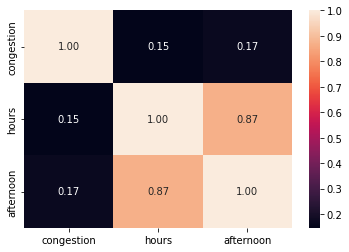

In [19]:
sns.heatmap(train[['congestion', 'hours', 'afternoon']].corr(), annot=True, fmt=".2f")

<AxesSubplot:xlabel='road', ylabel='congestion'>

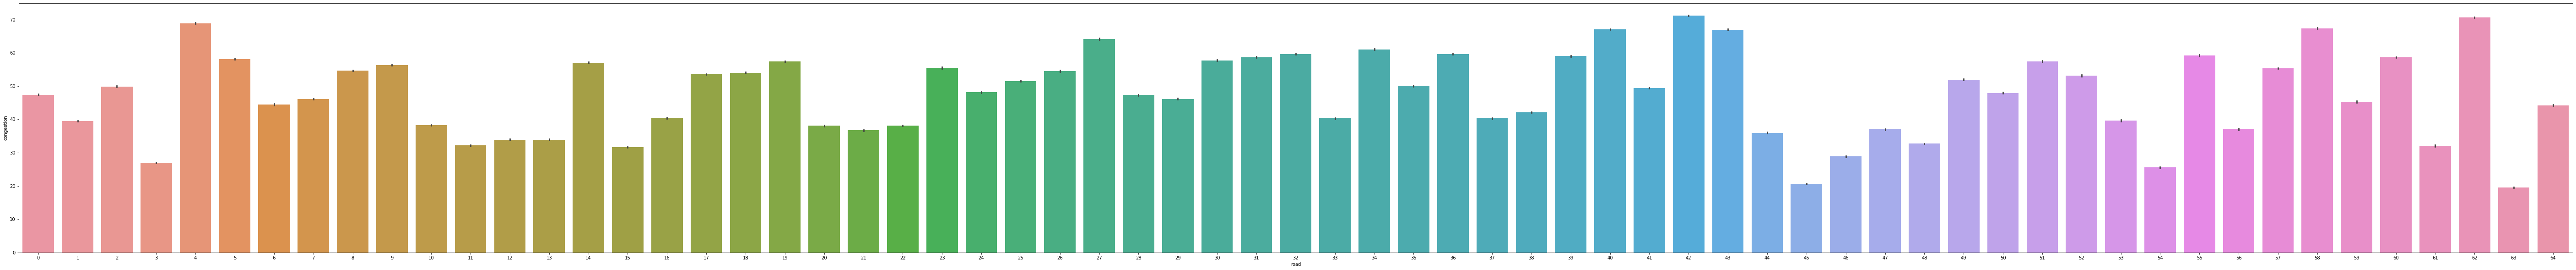

In [20]:
plt.figure(figsize=(100,10))
sns.barplot(x=train['road'],y=train['congestion'])

Text(0.5, 0, 'Congestion')

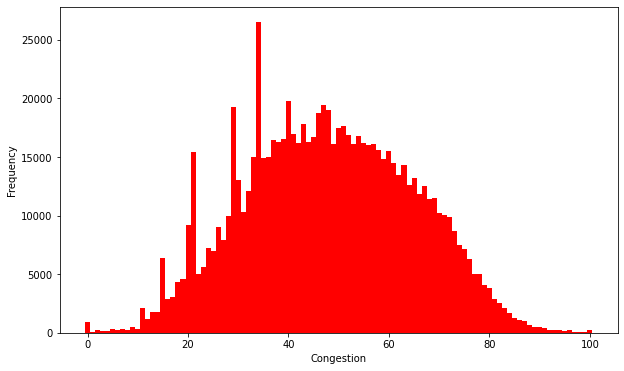

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(range(0,101),train.congestion.value_counts().sort_index(), width=1, color = "red")
plt.ylabel('Frequency')
plt.xlabel('Congestion')

**Creating a model**

In [22]:
tt.columns

Index(['time', 'congestion', 'month', 'day', 'weekday', 'weekend', 'hours',
       'minute', 'afternoon', 'road', 'mean congestion', 'median congestion',
       'min congestion', 'max congestion', 'morning_avg', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'],
      dtype='object')

In [23]:
x_train = tt[:len(train)]
y_train = x_train["congestion"]
x_test = tt[len(train):]

In [24]:
features = ["time","congestion", 'weekend',"weekday","month","day","morning_avg"]
x_train.drop(features, 1, inplace = True)
x_test.drop(features, 1, inplace = True)

In [25]:
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [26]:
y_valid.shape,x_valid.shape

((169767,), (169767, 15))

In [27]:
x_train.columns

Index(['hours', 'minute', 'afternoon', 'road', 'mean congestion',
       'median congestion', 'min congestion', 'max congestion', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'],
      dtype='object')

In [28]:
from catboost import CatBoostRegressor

cat_base = CatBoostRegressor(
    #ignored_features=ignore_cols,
    eval_metric='MAE')

In [29]:
cat_base.fit(x_train,y_train)

Learning rate set to 0.114715
0:	learn: 12.1353174	total: 153ms	remaining: 2m 33s
1:	learn: 11.1574900	total: 237ms	remaining: 1m 58s
2:	learn: 10.3139848	total: 314ms	remaining: 1m 44s
3:	learn: 9.6009324	total: 400ms	remaining: 1m 39s
4:	learn: 8.9806904	total: 478ms	remaining: 1m 35s
5:	learn: 8.4387612	total: 554ms	remaining: 1m 31s
6:	learn: 7.9809587	total: 633ms	remaining: 1m 29s
7:	learn: 7.5838032	total: 708ms	remaining: 1m 27s
8:	learn: 7.2536538	total: 780ms	remaining: 1m 25s
9:	learn: 6.9739322	total: 857ms	remaining: 1m 24s
10:	learn: 6.7323053	total: 938ms	remaining: 1m 24s
11:	learn: 6.5223410	total: 1.01s	remaining: 1m 23s
12:	learn: 6.3475874	total: 1.1s	remaining: 1m 23s
13:	learn: 6.2007247	total: 1.17s	remaining: 1m 22s
14:	learn: 6.0788346	total: 1.24s	remaining: 1m 21s
15:	learn: 5.9782545	total: 1.32s	remaining: 1m 21s
16:	learn: 5.8891726	total: 1.4s	remaining: 1m 20s
17:	learn: 5.8141939	total: 1.47s	remaining: 1m 20s
18:	learn: 5.7556449	total: 1.54s	remaining

In [30]:
pred_test=cat_base.predict(x_valid)
pred_train=cat_base.predict(x_train)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
print('Training Set:')
print("Mean absolute error:",(mean_absolute_error(y_train, pred_train)).round(2))
print("Mean squared error:",mean_squared_error(y_train, pred_train).round(2))
print("Coefficient of determination/Accuracy:",(r2_score(y_train, pred_train)*100).round(2),'%')

Training Set:
Mean absolute error: 5.26
Mean squared error: 54.76
Coefficient of determination/Accuracy: 78.3 %


In [33]:
print('Testing Set:')
print("Mean absolute error:",(mean_absolute_error(y_valid, pred_test)).round(2))
print("Mean squared error:",mean_squared_error(y_valid, pred_test).round(2))
print("Coefficient of determination/Accuracy:",(r2_score(y_valid, pred_test)*100).round(2),'%')

Testing Set:
Mean absolute error: 5.34
Mean squared error: 56.98
Coefficient of determination/Accuracy: 77.34 %


In [34]:
preds = pd.DataFrame(cat_base.predict(x_test), columns=['preds'])
preds = preds.round()
preds.head()

,preds
0,47.0
1,34.0
2,53.0
3,22.0
4,70.0


In [35]:
so = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv')


In [36]:
output = pd.DataFrame({'row_id': so.row_id,
                       'congestion': preds['preds']})
output.head()

,row_id,congestion
0,848835,47.0
1,848836,34.0
2,848837,53.0
3,848838,22.0
4,848839,70.0


In [37]:
output.to_csv('submission.csv', index=False)